In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.decomposition import NMF
from sklearn.preprocessing import LabelEncoder


In [2]:
train = pd.read_csv("../../input/train.csv")
test = pd.read_csv("../../input/test.csv")
anime = pd.read_csv("../../input/anime.csv")

In [3]:
train.head()

,user_id,anime_id,score
0,0008e10fb39e55447333,0669cc0219d468761195,2
1,0008e10fb39e55447333,111adb8835b8a1a2cf54,10
2,0008e10fb39e55447333,1fc8683c393432a2f9c7,1
3,0008e10fb39e55447333,2290175205d55e81b197,8
4,0008e10fb39e55447333,28f173b60331d5cabb0d,9


In [4]:
test.head()

,user_id,anime_id
0,0008e10fb39e55447333,04068820a73e52dc3b32
1,0008e10fb39e55447333,04a3d0b122b24965e909
2,0008e10fb39e55447333,1447fe1f10b59912d6a8
3,0008e10fb39e55447333,2622632598c68682afd5
4,0008e10fb39e55447333,2701850c7216516fec46


In [5]:
anime.head()

,anime_id,genres,japanese_name,type,episodes,aired,producers,licensors,studios,source,duration,rating,members,watching,completed,on_hold,dropped,plan_to_watch
0,000ba7f7e34e107e7544,"Comedy, Sci-Fi, Seinen, Slice of Life, Space",宇宙兄弟,TV,99,"Apr 1, 2012 to Mar 22, 2014","Aniplex, Dentsu, YTV, Trinity Sound",Sentai Filmworks,A-1 Pictures,Manga,24 min. per ep.,PG-13 - Teens 13 or older,150428,16552,37234,13009,6948,76685
1,00427279d72064e7fb69,"Adventure, Slice of Life, Mystery, Historical,...",蟲師,TV,26,"Oct 23, 2005 to Jun 19, 2006","Avex Entertainment, Marvelous, SKY Perfect Wel...",Funimation,Artland,Manga,25 min. per ep.,PG-13 - Teens 13 or older,620736,55482,235371,42786,20017,267080
2,00444b67aaabdf740a68,"Adventure, Slice of Life, Mystery, Historical,...",蟲師 続章,TV,10,"Apr 5, 2014 to Jun 21, 2014","Aniplex, Kodansha, Delfi Sound",Aniplex of America,Artland,Manga,24 min. per ep.,PG-13 - Teens 13 or older,226522,12585,113559,6095,2606,91677
3,00839a3507ab168abe75,"Comedy, Ecchi, Fantasy, School",星刻の竜騎士,TV,12,"Apr 5, 2014 to Jun 21, 2014","Media Factory, AT-X, Sony Music Communications...",Funimation,C-Station,Light novel,24 min. per ep.,R+ - Mild Nudity,170220,8723,118202,3753,8034,31508
4,0192331235e110fe4f76,"Comedy, Harem, Romance, Sci-Fi, Shounen, Space",天地無用！,TV,26,"Apr 2, 1995 to Sep 24, 1995","TV Tokyo, Pioneer LDC","Funimation, Geneon Entertainment USA",AIC,Original,23 min. per ep.,PG-13 - Teens 13 or older,62599,2565,39890,2093,1986,16065


<Axes: >

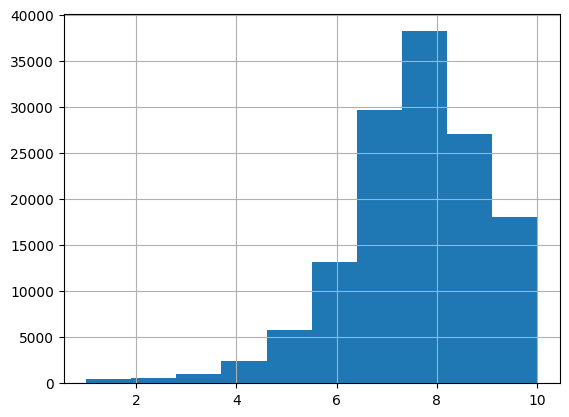

In [6]:
train["score"].hist()

In [7]:
train_test = pd.concat([train.drop(columns=["score"]), test]).reset_index(drop=True)

In [8]:
len(train_test) == len(train) + len(test)

True

In [9]:
train_test_anime = train_test.merge(anime, how="left", on="anime_id")

In [10]:
train_test_anime.head()

,user_id,anime_id,genres,japanese_name,type,episodes,aired,producers,licensors,studios,source,duration,rating,members,watching,completed,on_hold,dropped,plan_to_watch
0,0008e10fb39e55447333,0669cc0219d468761195,"Action, Adventure, Shounen",ジョジョの奇妙な冒険 黄金の風,TV,39,"Oct 6, 2018 to Jul 28, 2019","Warner Bros. Japan, KlockWorx, Medicos Enterta...",VIZ Media,David Production,Manga,23 min. per ep.,R - 17+ (violence & profanity),542642,64809,383733,10625,5735,77740
1,0008e10fb39e55447333,111adb8835b8a1a2cf54,"Action, Dementia, Demons, Horror, Supernatural",DEVILMAN crybaby,ONA,10,"Jan 5, 2018","Aniplex, Dynamic Planning, Netflix",Unknown,Science SARU,Manga,25 min. per ep.,R+ - Mild Nudity,650309,29665,477257,13336,18054,111997
2,0008e10fb39e55447333,1fc8683c393432a2f9c7,"Hentai, Yaoi",ぼくのぴこ,OVA,1,"Sep 7, 2006",Natural High,Unknown,"Sugar Boy, Blue Cat",Original,34 min.,Rx - Hentai,137560,5153,113190,758,9431,9028
3,0008e10fb39e55447333,2290175205d55e81b197,"Action, Slice of Life, Comedy, Supernatural",モブサイコ100,TV,12,"Jul 11, 2016 to Sep 27, 2016","Warner Bros. Japan, KlockWorx, BS Fuji, Hakuho...","Funimation, Crunchyroll",Bones,Web manga,24 min. per ep.,PG-13 - Teens 13 or older,1255830,68041,942402,26125,19213,200049
4,0008e10fb39e55447333,28f173b60331d5cabb0d,"Comedy, Shounen, Sports",はじめの一歩 -Champion Road-,Special,1,"Apr 18, 2003",Unknown,"Discotek Media, Geneon Entertainment USA",Madhouse,Manga,1 hr. 30 min.,PG-13 - Teens 13 or older,97346,1565,82189,502,379,12711


# Label Encoding

In [11]:
user_id_encoder = LabelEncoder()
train_test_anime["user_id_encoded"] = user_id_encoder.fit_transform(train_test_anime["user_id"])

In [12]:
anime_id_encoder = LabelEncoder()
train_test_anime["anime_id_encoded"] = anime_id_encoder.fit_transform(train_test_anime["anime_id"])

In [13]:
genres_encoder = LabelEncoder()
train_test_anime["genres_encoded"] = genres_encoder.fit_transform(train_test_anime["genres"])

In [14]:
producers_encoder = LabelEncoder()
train_test_anime["producers_encoded"] = producers_encoder.fit_transform(train_test_anime["producers"])

In [15]:
licensors_encoder = LabelEncoder()
train_test_anime["licensors_encoded"] = licensors_encoder.fit_transform(train_test_anime["licensors"])

In [16]:
studios_encoder = LabelEncoder()
train_test_anime["studios_encoded"] = studios_encoder.fit_transform(train_test_anime["studios"])

In [17]:
source_encoder = LabelEncoder()
train_test_anime["source_encoded"] = source_encoder.fit_transform(train_test_anime["source"])

# NMF

In [18]:
n_components = 128

In [19]:
user_anime_nmf = NMF(n_components=n_components, random_state=1013, alpha_W=0.01, max_iter=1000)
user_anime_count = pd.crosstab(train_test_anime["user_id_encoded"], train_test_anime["anime_id_encoded"])
user_anime_w = user_anime_nmf.fit_transform(user_anime_count)
user_anime_h = user_anime_nmf.components_

user_anime_w_cols = [f"user_anime_w_{i}" for i in range(n_components)]
user_anime_h_cols = [f"user_anime_h_{i}" for i in range(n_components)]

user_anime_w = pd.DataFrame(user_anime_w, index=user_anime_count.index, columns=user_anime_w_cols)
user_anime_h = pd.DataFrame(user_anime_h.T, index=user_anime_count.columns, columns=user_anime_h_cols)

train_test_anime = train_test_anime \
    .merge(user_anime_w, left_on="user_id_encoded", right_index=True, how="left") \
    .merge(user_anime_h, left_on="anime_id_encoded", right_index=True, how="left")

In [20]:
user_genres_nmf = NMF(n_components=n_components, random_state=1013, alpha_W=0.01, max_iter=1000)
user_genres_count = pd.crosstab(train_test_anime["user_id_encoded"], train_test_anime["genres_encoded"])
user_genres_w = user_genres_nmf.fit_transform(user_genres_count)
user_genres_h = user_genres_nmf.components_

user_genres_w_cols = [f"user_genres_w_{i}" for i in range(n_components)]
user_genres_h_cols = [f"user_genres_h_{i}" for i in range(n_components)]

user_genres_w = pd.DataFrame(user_genres_w, index=user_genres_count.index, columns=user_genres_w_cols)
user_genres_h = pd.DataFrame(user_genres_h.T, index=user_genres_count.columns, columns=user_genres_h_cols)

train_test_anime = train_test_anime \
    .merge(user_genres_w, left_on="user_id_encoded", right_index=True, how="left") \
    .merge(user_genres_h, left_on="genres_encoded", right_index=True, how="left")

In [21]:
user_producers_nmf = NMF(n_components=n_components, random_state=1013, alpha_W=0.01, max_iter=1000)
user_producers_count = pd.crosstab(train_test_anime["user_id_encoded"], train_test_anime["producers_encoded"])
user_producers_w = user_producers_nmf.fit_transform(user_producers_count)
user_producers_h = user_producers_nmf.components_

user_producers_w_cols = [f"user_producers_w_{i}" for i in range(n_components)]
user_producers_h_cols = [f"user_producers_h_{i}" for i in range(n_components)]

user_producers_w = pd.DataFrame(user_producers_w, index=user_producers_count.index, columns=user_producers_w_cols)
user_producers_h = pd.DataFrame(user_producers_h.T, index=user_producers_count.columns, columns=user_producers_h_cols)

train_test_anime = train_test_anime \
    .merge(user_producers_w, left_on="user_id_encoded", right_index=True, how="left") \
    .merge(user_producers_h, left_on="producers_encoded", right_index=True, how="left")

In [22]:
user_licensors_nmf = NMF(n_components=n_components, random_state=1013, alpha_W=0.01, max_iter=1000)
user_licensors_count = pd.crosstab(train_test_anime["user_id_encoded"], train_test_anime["licensors_encoded"])
user_licensors_w = user_licensors_nmf.fit_transform(user_licensors_count)
user_licensors_h = user_licensors_nmf.components_

user_licensors_w_cols = [f"user_licensors_w_{i}" for i in range(n_components)]
user_licensors_h_cols = [f"user_licensors_h_{i}" for i in range(n_components)]

user_licensors_w = pd.DataFrame(user_licensors_w, index=user_licensors_count.index, columns=user_licensors_w_cols)
user_licensors_h = pd.DataFrame(user_licensors_h.T, index=user_licensors_count.columns, columns=user_licensors_h_cols)

train_test_anime = train_test_anime \
    .merge(user_licensors_w, left_on="user_id_encoded", right_index=True, how="left") \
    .merge(user_licensors_h, left_on="licensors_encoded", right_index=True, how="left")

In [23]:
user_studios_nmf = NMF(n_components=n_components, random_state=1013, alpha_W=0.01, max_iter=1000)
user_studios_count = pd.crosstab(train_test_anime["user_id_encoded"], train_test_anime["studios_encoded"])
user_studios_w = user_studios_nmf.fit_transform(user_studios_count)
user_studios_h = user_studios_nmf.components_

user_studios_w_cols = [f"user_studios_w_{i}" for i in range(n_components)]
user_studios_h_cols = [f"user_studios_h_{i}" for i in range(n_components)]

user_studios_w = pd.DataFrame(user_studios_w, index=user_studios_count.index, columns=user_studios_w_cols)
user_studios_h = pd.DataFrame(user_studios_h.T, index=user_studios_count.columns, columns=user_studios_h_cols)

train_test_anime = train_test_anime \
    .merge(user_studios_w, left_on="user_id_encoded", right_index=True, how="left") \
    .merge(user_studios_h, left_on="studios_encoded", right_index=True, how="left")

In [24]:
user_source_nmf = NMF(n_components=n_components, random_state=1013, alpha_W=0.01, max_iter=1000)
user_source_count = pd.crosstab(train_test_anime["user_id_encoded"], train_test_anime["source_encoded"])
user_source_w = user_source_nmf.fit_transform(user_source_count)
user_source_h = user_source_nmf.components_

user_source_w_cols = [f"user_source_w_{i}" for i in range(n_components)]
user_source_h_cols = [f"user_source_h_{i}" for i in range(n_components)]

user_source_w = pd.DataFrame(user_source_w, index=user_source_count.index, columns=user_source_w_cols)
user_source_h = pd.DataFrame(user_source_h.T, index=user_source_count.columns, columns=user_source_h_cols)

train_test_anime = train_test_anime \
    .merge(user_source_w, left_on="user_id_encoded", right_index=True, how="left") \
    .merge(user_source_h, left_on="source_encoded", right_index=True, how="left")

In [25]:
train_test_anime.head()

,user_id,anime_id,genres,japanese_name,type,episodes,aired,producers,licensors,studios,...,user_source_h_118,user_source_h_119,user_source_h_120,user_source_h_121,user_source_h_122,user_source_h_123,user_source_h_124,user_source_h_125,user_source_h_126,user_source_h_127
0,0008e10fb39e55447333,0669cc0219d468761195,"Action, Adventure, Shounen",ジョジョの奇妙な冒険 黄金の風,TV,39,"Oct 6, 2018 to Jul 28, 2019","Warner Bros. Japan, KlockWorx, Medicos Enterta...",VIZ Media,David Production,...,0.0,0.000000,2.565421,0.000000,0.0,1.174696,0.0,0.955454,0.0,0.0
1,0008e10fb39e55447333,111adb8835b8a1a2cf54,"Action, Dementia, Demons, Horror, Supernatural",DEVILMAN crybaby,ONA,10,"Jan 5, 2018","Aniplex, Dynamic Planning, Netflix",Unknown,Science SARU,...,0.0,0.000000,2.565421,0.000000,0.0,1.174696,0.0,0.955454,0.0,0.0
2,0008e10fb39e55447333,1fc8683c393432a2f9c7,"Hentai, Yaoi",ぼくのぴこ,OVA,1,"Sep 7, 2006",Natural High,Unknown,"Sugar Boy, Blue Cat",...,0.0,0.162594,0.000000,1.808223,0.0,1.616826,0.0,0.000000,0.0,0.0
3,0008e10fb39e55447333,2290175205d55e81b197,"Action, Slice of Life, Comedy, Supernatural",モブサイコ100,TV,12,"Jul 11, 2016 to Sep 27, 2016","Warner Bros. Japan, KlockWorx, BS Fuji, Hakuho...","Funimation, Crunchyroll",Bones,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0
4,0008e10fb39e55447333,28f173b60331d5cabb0d,"Comedy, Shounen, Sports",はじめの一歩 -Champion Road-,Special,1,"Apr 18, 2003",Unknown,"Discotek Media, Geneon Entertainment USA",Madhouse,...,0.0,0.000000,2.565421,0.000000,0.0,1.174696,0.0,0.955454,0.0,0.0


# Fold

In [26]:
from sklearn.model_selection import KFold, GroupKFold

class UnknownUserKFold:
    def __init__(self, n_splits_cv: int, n_splits_uu: int):
        self.n_splits_cv = n_splits_cv
        self.n_splits_uu = n_splits_uu

    def split(self, X, y=None, groups=None):
        splits_cv = KFold(n_splits=self.n_splits_cv, shuffle=True, random_state=0).split(X)
        splits_uu = GroupKFold(n_splits=self.n_splits_uu).split(X, groups=groups)
        for fold in range(self.n_splits_cv):
            train_index, test_index = next(splits_cv)
            _, uu_index = next(splits_uu)
            train_index = np.setdiff1d(train_index, uu_index)
            test_index = np.union1d(test_index, uu_index)

            yield train_index, test_index

# Training

In [27]:
features = []
features += user_anime_w_cols
features += user_anime_h_cols
features += user_genres_w_cols
features += user_genres_h_cols
features += user_producers_w_cols
features += user_producers_h_cols
features += user_licensors_w_cols
features += user_licensors_h_cols
features += user_studios_w_cols
features += user_studios_h_cols
features += user_source_w_cols
features += user_source_h_cols

In [28]:
train_X = train_test_anime.iloc[:len(train)][features].reset_index(drop=True)
train_y = train["score"].reset_index(drop=True)
test_X = train_test_anime.iloc[len(train):][features].reset_index(drop=True)

In [29]:
params = {
    'seed': 1013,
    'objective': 'regression',
    'metric': 'rmse',
    'learning_rate': 0.01,
    'num_leaves': 64,
    'lambda_l1': 0.1,
    'lambda_l2': 0.1,
    'feature_fraction': 0.7,
    'verbose': -1
}

In [40]:
models = []
oof_prediction = np.zeros(len(train))
test_predictions = []
kf = UnknownUserKFold(n_splits_cv=5, n_splits_uu=18)

for fold, (train_idx, valid_idx) in enumerate(kf.split(train_X, groups=train["user_id"])):
    _train_X = train_X.iloc[train_idx]
    _train_y = train_y.iloc[train_idx]
    _valid_X = train_X.iloc[valid_idx]
    _valid_y = train_y.iloc[valid_idx]
    
    model = lgb.train(
        params,
        train_set=lgb.Dataset(_train_X, label=_train_y),
        valid_sets=[lgb.Dataset(_valid_X, label=_valid_y)],
        num_boost_round=20000,
        callbacks=[
            lgb.early_stopping(stopping_rounds=500, verbose=True),
            lgb.log_evaluation(500)
        ]
    )

    oof_prediction[valid_idx] = model.predict(_valid_X)

    test_predictions.append(model.predict(test_X))

Training until validation scores don't improve for 500 rounds
[500]	valid_0's rmse: 1.24456
[1000]	valid_0's rmse: 1.21056
[1500]	valid_0's rmse: 1.20105
[2000]	valid_0's rmse: 1.19439
[2500]	valid_0's rmse: 1.18912
[3000]	valid_0's rmse: 1.18506
[3500]	valid_0's rmse: 1.18172


KeyboardInterrupt: 